In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from kneed import KneeLocator
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import warnings
from sklearn.metrics import pairwise_distances_argmin_min
warnings.filterwarnings('ignore')

In [ ]:
# load in csv
clean_df = pd.read_csv('cleaned_goodreads_reviews.csv', index_col=0)

clean_df

,reviews
0,local bookseller ever read firmly going either...
1,march nymphet never think year old way stain b...
2,going embarrassing know reading enjoying book ...
3,even going write review finishing honestly man...
4,first read book every second pride reader dist...
...,...
5965,august harry levin great book darkly symbolica...
5966,light life fire
5967,may murder roger de remember seeing interview ...
5968,sulfurous scandalous novel reader ethic bring ...


In [ ]:
#calculating sentiment for reviews
# initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# analyze sentiment for reviews
sentiment_scores = []
for review in clean_df['reviews']:
    scores = sid.polarity_scores(review)
    sentiment_scores.append(scores)

# add sentiment scores to dataset
sentiment_df = pd.DataFrame(sentiment_scores)
s_df = pd.concat([clean_df, sentiment_df], axis=1)

# classify sentiment based on the compound score
def classify_sentiment(score):
    if score >= 0.75:
        return 'extremely positive'
    elif score >= 0.25:
        return 'positive'
    elif score >= 0.05:
        return 'slightly positive'
    elif score > -0.05:
        return 'neutral'
    elif score > -0.25:
        return 'slightly negative'
    elif score > -0.75:
        return 'negative'
    else:
        return 'extremely negative'

# save sentiment values to new dataset
s_df['sentiment'] = s_df['compound'].apply(classify_sentiment)
s_df

,reviews,neg,neu,pos,compound,sentiment
0,local bookseller ever read firmly going either...,0.196,0.547,0.258,0.9980,extremely positive
1,march nymphet never think year old way stain b...,0.152,0.694,0.154,-0.2615,negative
2,going embarrassing know reading enjoying book ...,0.215,0.501,0.285,0.9640,extremely positive
3,even going write review finishing honestly man...,0.152,0.557,0.291,0.9623,extremely positive
4,first read book every second pride reader dist...,0.191,0.550,0.260,0.8639,extremely positive
...,...,...,...,...,...,...
5965,august harry levin great book darkly symbolica...,0.252,0.524,0.224,-0.7783,extremely negative
5966,light life fire,0.545,0.455,0.000,-0.3400,negative
5967,may murder roger de remember seeing interview ...,0.196,0.594,0.210,-0.6396,negative
5968,sulfurous scandalous novel reader ethic bring ...,0.262,0.522,0.217,-0.7200,negative


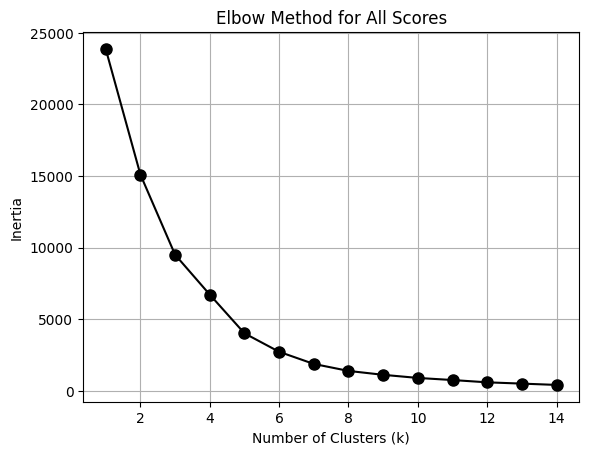

In [ ]:
features = ['neg', 'neu', 'pos', 'compound']
X = s_df[features]
O
#standardize the features
#standardization is used to make sure each feature contributes equally to
#the model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#apply elbow method
#inertia is a measure of how well the clusters formed
#it quantifies the compactness of the clusters at a certain k value.
inertia = []
k_val = range(1,15)
for k in k_val:
    kmeans = KMeans(n_clusters=k, random_state=3)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

#plot elbow
plt.plot(k_val, inertia, 'k-o', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for All Scores')
plt.grid(True)
plt.show()

#the rate of decrease slows down after 5, so the k-value we should use is 5

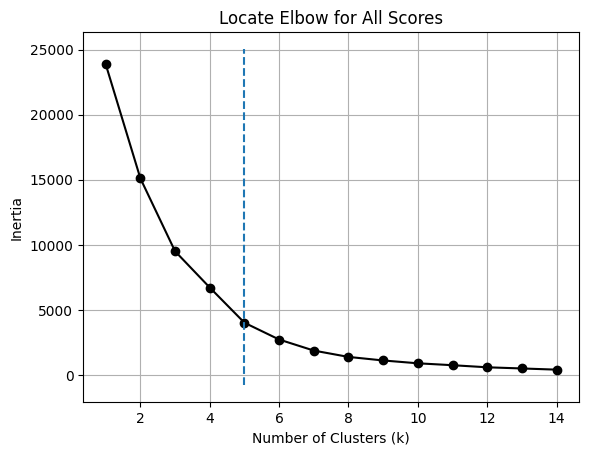

In [ ]:
kn = KneeLocator(k_val, inertia, curve='convex', direction='decreasing')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Locate Elbow for All Scores')
plt.plot(k_val, inertia, 'k-o')
plt.grid()
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [ ]:
k = 5
#perform k-means, set number of clusters to be the k value we found from
#the elbow method above
#random_state should be same as value above
kmeans = KMeans(n_clusters=k, random_state=3)
s_df['cluster'] = kmeans.fit_predict(X_scaled)

s_df

,reviews,neg,neu,pos,compound,sentiment,cluster
0,local bookseller ever read firmly going either...,0.196,0.547,0.258,0.9980,extremely positive,0
1,march nymphet never think year old way stain b...,0.152,0.694,0.154,-0.2615,negative,1
2,going embarrassing know reading enjoying book ...,0.215,0.501,0.285,0.9640,extremely positive,0
3,even going write review finishing honestly man...,0.152,0.557,0.291,0.9623,extremely positive,0
4,first read book every second pride reader dist...,0.191,0.550,0.260,0.8639,extremely positive,0
...,...,...,...,...,...,...,...
5965,august harry levin great book darkly symbolica...,0.252,0.524,0.224,-0.7783,extremely negative,1
5966,light life fire,0.545,0.455,0.000,-0.3400,negative,3
5967,may murder roger de remember seeing interview ...,0.196,0.594,0.210,-0.6396,negative,1
5968,sulfurous scandalous novel reader ethic bring ...,0.262,0.522,0.217,-0.7200,negative,1


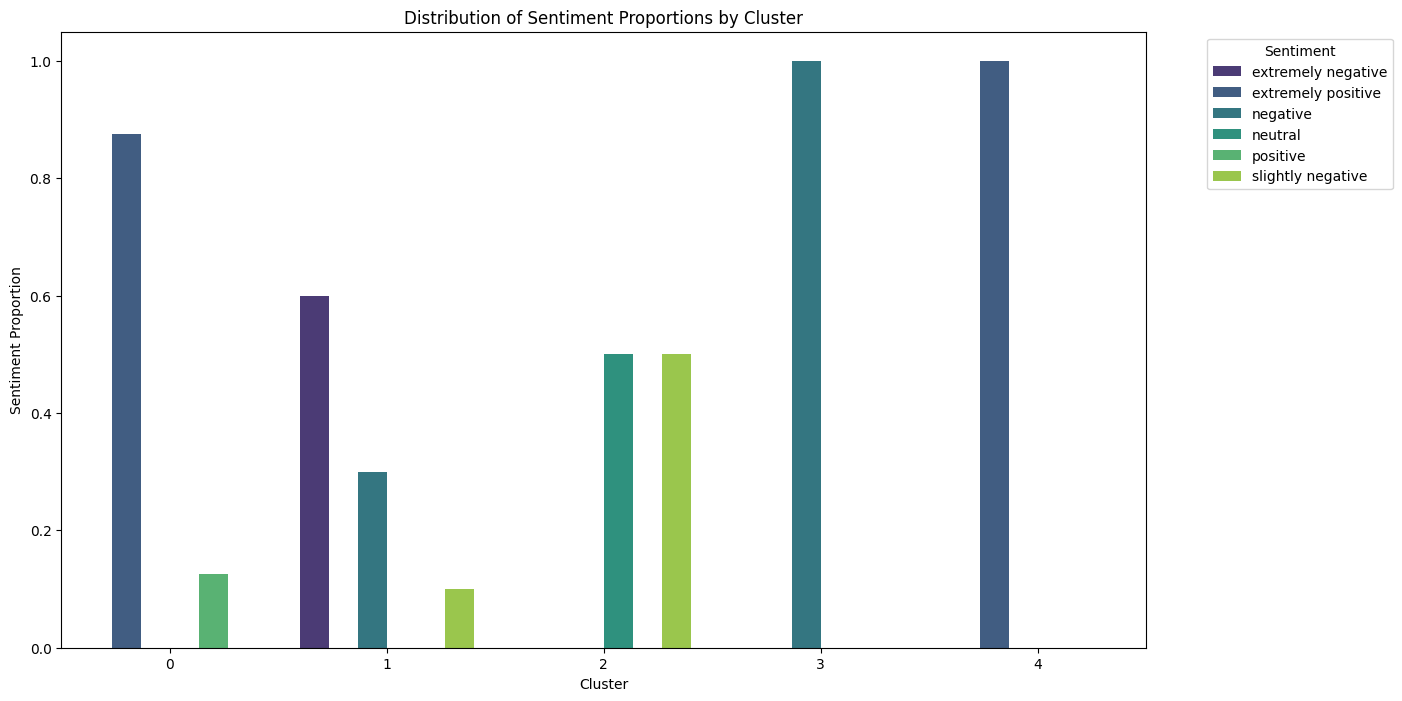

In [ ]:
#distribution of sentiment labels in each cluster
sentiment_distribution = s_df.groupby('cluster')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
sentiment_distribution_reset = sentiment_distribution.reset_index()

#distribution of compound values in each cluster

# Melt the DataFrame
melted_sentiment_distribution = sentiment_distribution_reset.melt(id_vars='cluster', var_name='Sentiment',
                                                                  value_name='Proportion')

# Create a bar chart for the sentiment distribution by cluster
plt.figure(figsize=(14, 8))
sns.barplot(data=melted_sentiment_distribution, x='cluster', y='Proportion', hue='Sentiment', palette='viridis')
plt.title('Distribution of Sentiment Proportions by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Sentiment Proportion')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

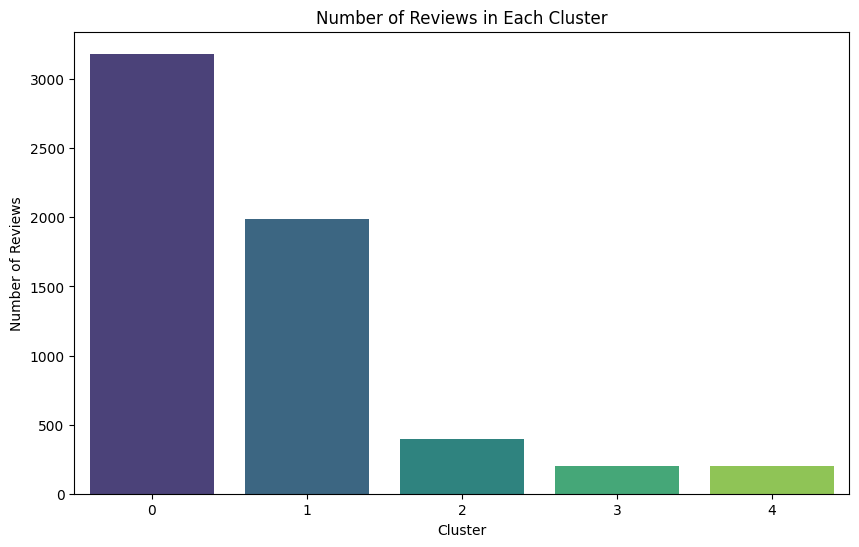

In [ ]:
review_counts = s_df['cluster'].value_counts().reset_index()
review_counts.columns = ['cluster', 'count']

# Create a bar chart for the number of reviews in each cluster
plt.figure(figsize=(10, 6))
sns.barplot(data=review_counts, x='cluster', y='count', palette='viridis')
plt.title('Number of Reviews in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Reviews')
plt.show()

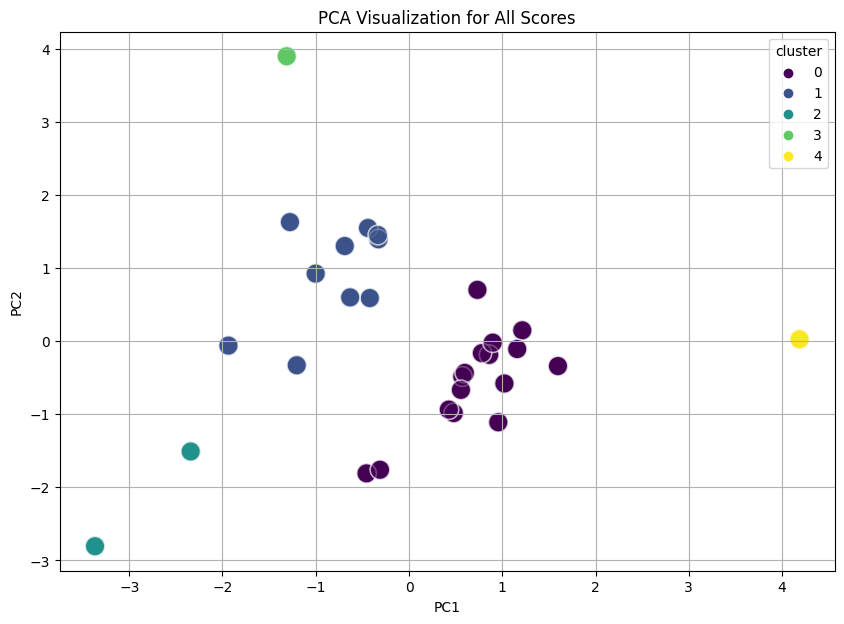

In [ ]:
#a dimensionality reduction method that is often used to reduce the
#dimensionality of large data sets, by transforming a large set
#of variables into a smaller one that still contains most of the
#information in the large set
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = s_df['cluster']
pca_df

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster',
                palette='viridis', s=200, alpha=.6)
plt.title('PCA Visualization for All Scores')
plt.grid()
plt.show()

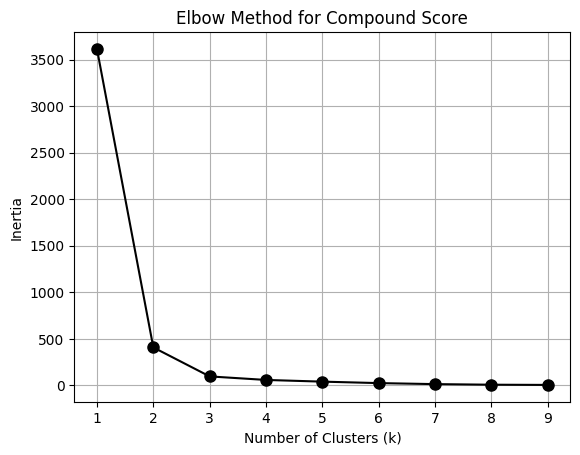

In [ ]:
#plotting elbow method, approach 2 (k-means on compound scores)
#reshaping compound values for kmeans
compound_scores = s_df['compound'].values.reshape(-1, 1)

# determine optimal # of clusters using elbow method
inertia = []
k_val = range(1,10)
for k in k_val:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(compound_scores)
    inertia.append(kmeans.inertia_)

# plot the elbow method
plt.plot(k_val, inertia, 'k-o', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Compound Score')
plt.grid()
plt.show()

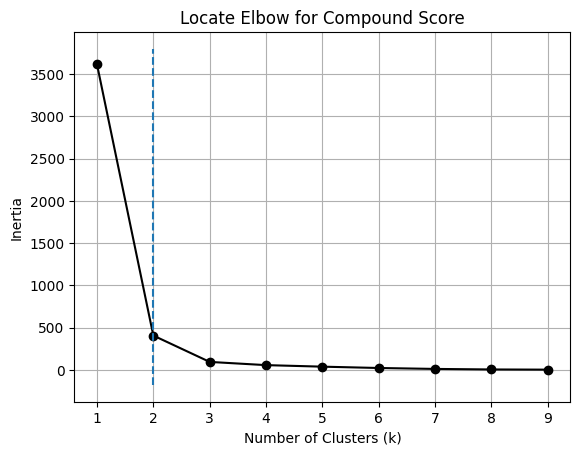

In [ ]:
from kneed import KneeLocator
kn = KneeLocator(k_val, inertia, curve='convex', direction='decreasing')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Locate Elbow for Compound Score')
plt.plot(k_val, inertia, 'k-o')
plt.grid()
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [ ]:
# apply K-means
k=2
kmeans = KMeans(n_clusters=k, random_state=10)
s_df['cluster'] = kmeans.fit_predict(X)
s_df

,reviews,neg,neu,pos,compound,sentiment,cluster
0,local bookseller ever read firmly going either...,0.196,0.547,0.258,0.9980,extremely positive,0
1,march nymphet never think year old way stain b...,0.152,0.694,0.154,-0.2615,negative,1
2,going embarrassing know reading enjoying book ...,0.215,0.501,0.285,0.9640,extremely positive,0
3,even going write review finishing honestly man...,0.152,0.557,0.291,0.9623,extremely positive,0
4,first read book every second pride reader dist...,0.191,0.550,0.260,0.8639,extremely positive,0
...,...,...,...,...,...,...,...
5965,august harry levin great book darkly symbolica...,0.252,0.524,0.224,-0.7783,extremely negative,1
5966,light life fire,0.545,0.455,0.000,-0.3400,negative,1
5967,may murder roger de remember seeing interview ...,0.196,0.594,0.210,-0.6396,negative,1
5968,sulfurous scandalous novel reader ethic bring ...,0.262,0.522,0.217,-0.7200,negative,1


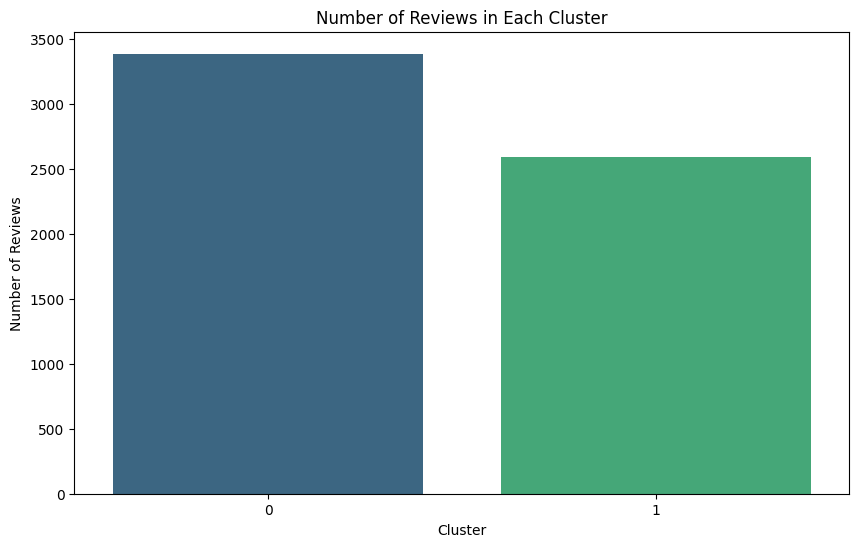

In [ ]:
# Summary statistics for each cluster
review_counts = s_df['cluster'].value_counts().sort_index()

# Create a bar chart for the number of reviews in each cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=review_counts.index, y=review_counts.values,
            palette='viridis')
plt.title('Number of Reviews in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=review_counts.index)
plt.show()

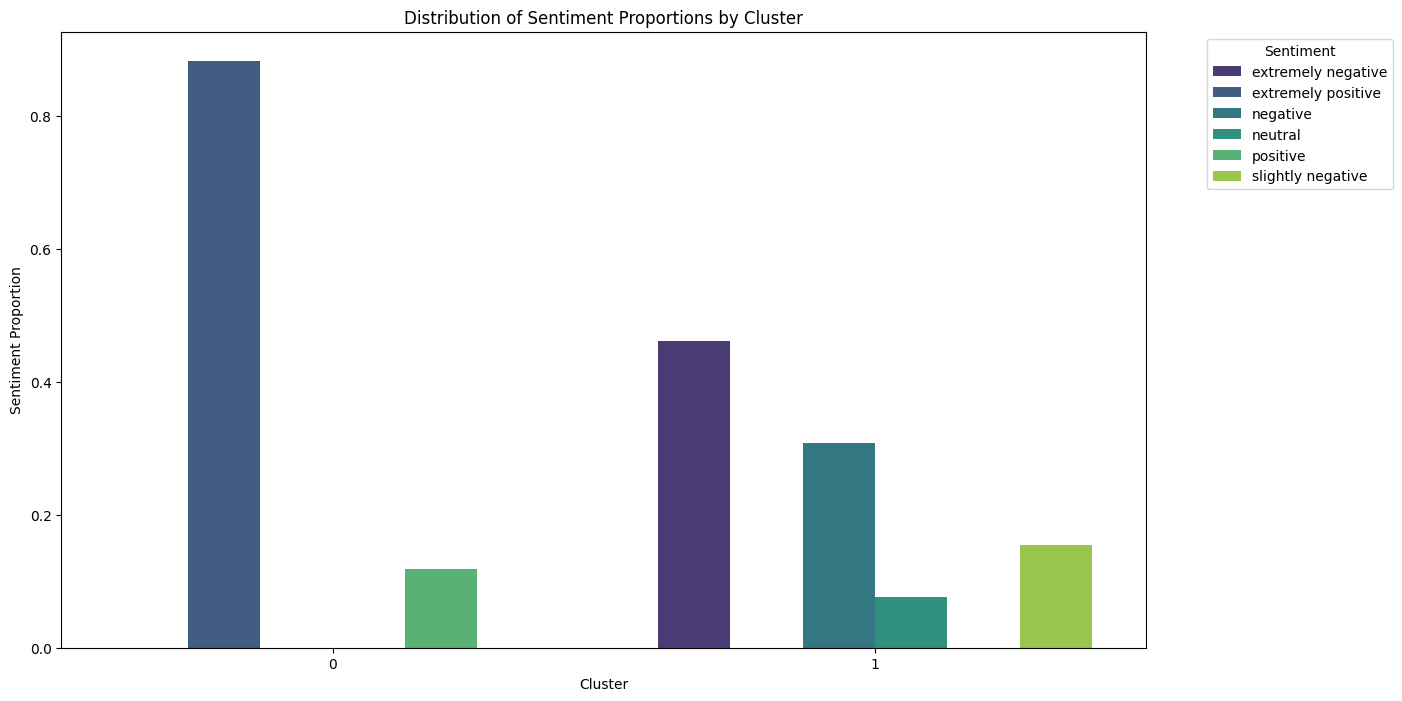

In [ ]:
s_df['sentiment'] = s_df['compound'].apply(classify_sentiment)

# Calculate the sentiment distribution
sentiment_distribution = s_df.groupby('cluster')['sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Reset the index to turn the index into columns
sentiment_distribution_reset = sentiment_distribution.reset_index()

# Melt the DataFrame
melted_sentiment_distribution = sentiment_distribution_reset.melt(id_vars='cluster', var_name='Sentiment', value_name='Proportion')

# Create a bar chart for the sentiment distribution by cluster
plt.figure(figsize=(14, 8))
sns.barplot(data=melted_sentiment_distribution, x='cluster', y='Proportion', hue='Sentiment', palette='viridis')
plt.title('Distribution of Sentiment Proportions by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Sentiment Proportion')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

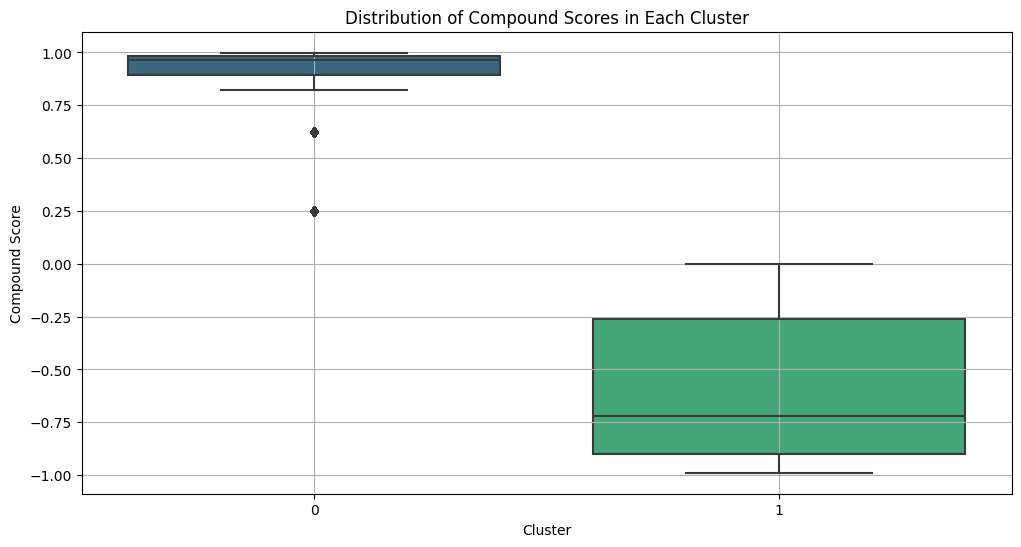

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='compound', data=s_df, palette='viridis')
plt.title('Distribution of Compound Scores in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Compound Score')
plt.grid()
plt.show()